In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as pl
import sklearn.cluster
import geopandas as gdp
import sklearn.cluster
from sklearn.cluster import DBSCAN
from scipy.cluster.vq import kmeans2
import scipy.cluster as scp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [ ]:
# Get data from source
# Updated per changed location
!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [ ]:
# Get NYC shape file
!wget -O shp.zip https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

In [ ]:
# Sorry, using shell commands to unzip Census data
!for ((y=94; y<=99; y+=1)); do unzip "zbp"$y"totals.zip"; done
!for ((y=0; y<=9; y+=1)); do unzip "zbp0"$y"totals.zip"; done
!for ((y=10; y<=14; y+=1)); do unzip "zbp"$y"totals.zip"; done
# Unzip NYC shape files
!unzip "shp.zip"

# Data cleaning

In [2]:
nyc_zips_df = gdp.GeoDataFrame.from_file("ZIP_CODE_040114.shp")

In [3]:
nyc_zips = nyc_zips_df['ZIPCODE'].unique().astype(int)

In [4]:
# Hacky ugly code to create data frame for each year, modify the headers
df94 = pd.read_csv("zbp94totals.txt")
df94["year"] = 1994
df95 = pd.read_csv("zbp95totals.txt")
df95["year"] = 1995
df96 = pd.read_csv("zbp96totals.txt")
df96["year"] = 1996
df97 = pd.read_csv("zbp97totals.txt")
df97["year"] = 1997
df98 = pd.read_csv("zbp98totals.txt")
df98["year"] = 1998
df98.columns = map(str.lower, df98.columns)
df99 = pd.read_csv("zbp99totals.txt")
df99.columns = map(str.lower, df99.columns)
df99["year"] = 1999
df00 = pd.read_csv("zbp00totals.txt")
df00.columns = map(str.lower, df00.columns)
df00["year"] = 2000
df01 = pd.read_csv("zbp01totals.txt")
df01.columns = map(str.lower, df01.columns)
df01["year"] = 2001
df02 = pd.read_csv("zbp02totals.txt")
df02.columns = map(str.lower, df02.columns)
df02["year"] = 2002
df03 = pd.read_csv("zbp03totals.txt")
df03.columns = map(str.lower, df03.columns)
df03["year"] = 2003
df04 = pd.read_csv("zbp04totals.txt")
df04.columns = map(str.lower, df04.columns)
df04["year"] = 2004
df05 = pd.read_csv("zbp05totals.txt")
df05.columns = map(str.lower, df05.columns)
df05["year"] = 2005
df06 = pd.read_csv("zbp06totals.txt")
df06.columns = map(str.lower, df06.columns)
df06["year"] = 2006
df07 = pd.read_csv("zbp07totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df07["year"] = 2007
df08 = pd.read_csv("zbp08totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df08["year"] = 2008
df09 = pd.read_csv("zbp09totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df09["year"] = 2009
df10 = pd.read_csv("zbp10totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df10["year"] = 2010
df11 = pd.read_csv("zbp11totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df11["year"] = 2011
df12 = pd.read_csv("zbp12totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df12["year"] = 2012
df13 = pd.read_csv("zbp13totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df13["year"] = 2013
df14 = pd.read_csv("zbp14totals.txt")[['zip','name','empflag','emp','qp1','ap','est']]
df14["year"] = 2014

In [5]:
# Create full list of data frames and join them together
dfs = [df94, df95, df96, df97,
      df98, df99, df00, df01,
      df02, df03, df04, df05,
      df06, df07, df08, df09,
      df10, df11, df12, df13,
      df14]
mydata0 = pd.concat(dfs)

In [6]:
# Filter to only NYC zip codes
mydata1 = mydata0[mydata0['zip'].isin(nyc_zips)][['zip','year','est']]

mydata1.head()

,zip,year,est
2966,10001,1994,6999
2967,10002,1994,1784
2968,10003,1994,3256
2969,10004,1994,1115
2970,10005,1994,1076


In [7]:
# Pivot by year and remove any nulls
mydata1 = mydata1.pivot(index='zip', columns='year', values='est').dropna()

mydata1.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [8]:
# Quasi-whiten data (normalize)
mydata = mydata1

for elem in range(len(mydata)):
    mydata.iloc[elem] = (mydata.iloc[elem] - mydata.iloc[elem].mean()) / mydata.iloc[elem].std()

mydata.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [9]:
# Set number of clusters and perform k-means clustering
nk = 5
np.random.seed(111)
c1 = sklearn.cluster.KMeans(n_clusters=nk).fit(mydata)   

In [10]:
mydata['cluster'] = c1.labels_

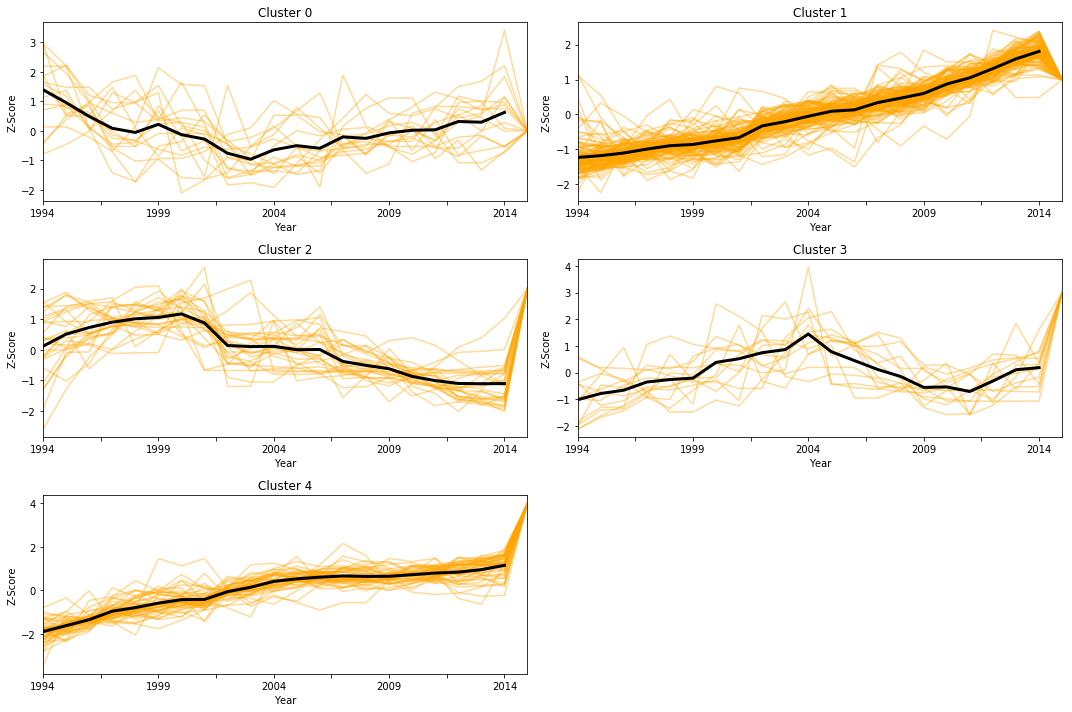

In [11]:
# Plot trend and cluster center for each of the 5 clusters
# Ugly technique but it works
fig = plt.figure(figsize=[15,10])

for elem in range(nk):
    
    ax = fig.add_subplot(3,2,elem + 1)
    
    mydata[mydata['cluster'] == elem][:-1].transpose().plot(legend=False, 
                                                            ax=ax, 
                                                            color = 'orange', 
                                                            alpha = 0.4)
    
    plt.plot(mydata.transpose()[:-1].index.astype(int)-1994, c1.cluster_centers_[elem], 
             color='black', 
             linewidth=3)
    
    ax.set_title('Cluster ' + str(elem))
    ax.set_xlabel('Year')
    ax.set_ylabel('Z-Score')
    
    plt.tight_layout()

<b>Figure 1</b>: K-means clustering results for clusters=5. Largest group shows a steady increase over time in the number of establishments. Probably could have used 4 clusters - clusters 1 and 5 are very similar.

In [12]:
# Add kmeans cluster result to data frame and prepare for merge
mrg_df = pd.DataFrame(mydata['cluster'])
mrg_df['ZIPCODE'] = mrg_df.index

In [13]:
# Join field to int for merge
nyc_zips_df['ZIPCODE'] = nyc_zips_df['ZIPCODE'].astype(int)
nyc_zips_df = nyc_zips_df.merge(mrg_df, how='left')

# Cluster to string so legend is discrete rather than continuous
nyc_zips_df['cluster'] = nyc_zips_df['cluster'].astype(str)

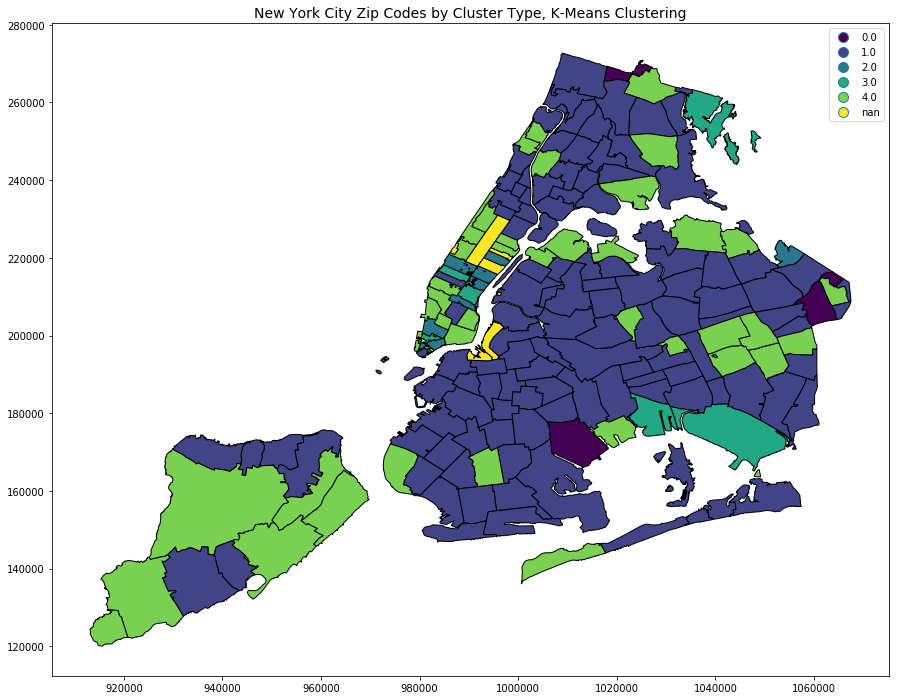

In [14]:
# Plot clusters on top of NYC zip code map
fig, ax = plt.subplots(figsize=(15,12))
nyc_zips_df.plot(column='cluster', 
                 edgecolor='black', 
                 cmap='viridis', 
                 ax=ax, 
                 legend=True)
ax.set_title('New York City Zip Codes by Cluster Type, K-Means Clustering', 
             fontsize=14)

<b>Figure 2</b>: Map of New York City zip codes by cluster (clusters = 5, k-means). Bulk of city is cluster 1 (strong increase) or cluster 4 (mild increase). Most areas of decrease (albeit minor) are interestingly around Midtown Manhattan. Some areas are null and unavailable in the Census data.

<h3>Second clustering type = DB Scan</h3>

In [15]:
db = DBSCAN(eps=3).fit(mydata)
labels = (db.labels_).astype(int)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([mydata[labels == i] for i in range(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 3


Note: number of clusters is set by the algorithm for DB Scan

In [16]:
# Add results to data frame
mydata['agg'] = labels

# Prepare for merge
agg_df = pd.DataFrame(mydata['agg'])
agg_df['ZIPCODE'] = agg_df.index

In [17]:
# Join field to int for merge
nyc_zips_df = nyc_zips_df.merge(agg_df, how='left')

# Cluster to string so legend is discrete rather than continuous
nyc_zips_df['agg'] = nyc_zips_df['agg'].astype(str)

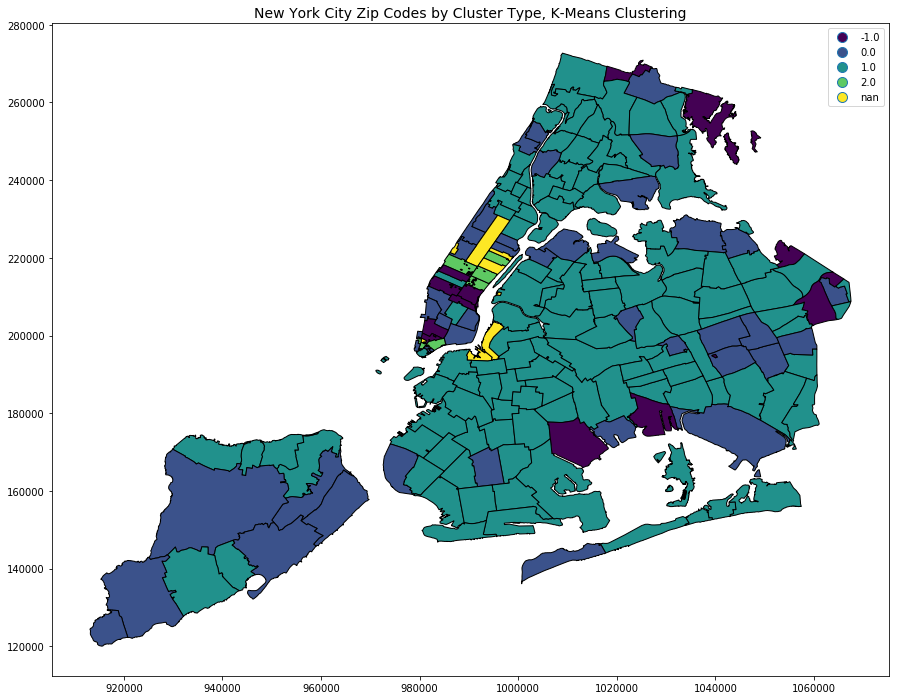

In [18]:
fig, ax = plt.subplots(figsize=(15,12))
nyc_zips_df.plot(column='agg', 
                 edgecolor='black', 
                 cmap='viridis', 
                 ax=ax, 
                 legend=True)
ax.set_title('New York City Zip Codes by Cluster Type, K-Means Clustering', fontsize=14)

<b>Figure 3:</b> New York City zip code map again with DBScan clustering algorithm. Many values in -1 = outlier, so it seems like my calculation threw out many areas as outliers, perhaps erroneously. Generally the same pattern - most of the city increased but Midtown Manhattan shows a different pattern, as well as some parts of Upper Manhattan and southern Brooklyn/Queens near JFK.

<h3>Quick stab at the dendogram

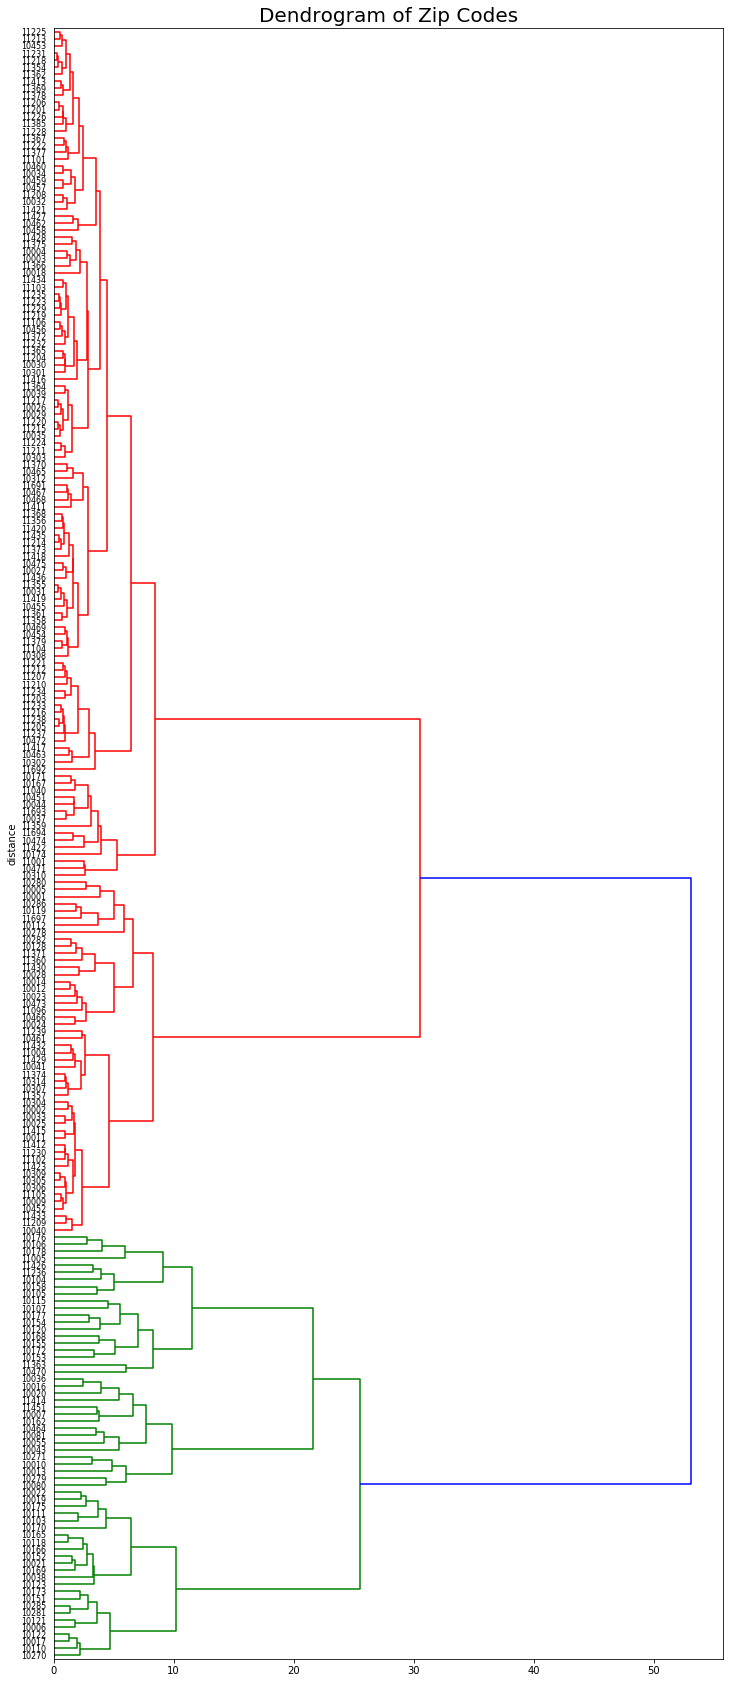

In [19]:
fig = plt.figure(figsize=(12,30))
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(mydata, method='ward'),
                               labels = mydata.index.values, orientation='right',
                               leaf_font_size=8)
pl.grid('off')
title = pl.title("Dendrogram of Zip Codes", fontsize=20)

<b>Figure 4</b>: Quick dendrogram plot. Two major groups in the plot - red and blue. I'm guessing that the large red group corresponds with the increase group that makes up the bulk of the city in the two examples above.